In [27]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
import torch
import torch.nn as nn
from Resnet import resnet34

In [29]:
sensor = pd.read_csv('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
train_meta = pq.ParquetFile('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet')
it = train_meta.iter_batches()
train_meta = next(it).to_pandas()

In [30]:
train_meta.head(20)

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
5,1,77,352,401,0.011372,1.295371
6,1,79,402,717,3.533397,2.479947
7,1,82,718,762,5.252108,0.672366
8,1,121,763,803,3.084929,2.065880
9,1,127,804,846,6.154335,1.371721


In [31]:
sensor.head(20)

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
5,5,-256.14,-521.08,410.93
6,6,-256.14,-521.08,393.91
7,7,-256.14,-521.08,376.88
8,8,-256.14,-521.08,359.86
9,9,-256.14,-521.08,342.84


In [38]:
import torch.nn as nn
model = resnet34(pretrained = False)
model.fc = nn.Sequential(nn.ReLU(),nn.Linear(in_features=512, out_features=2)) # Changed FC layer for our task

In [42]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float).to(device) # Tensor for prediction value appending
    actual = torch.tensor([], dtype=torch.float).to(device) # Tensor for answer value appending
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data['input_tensor'].float().to(device),data['label'].to(device)
            outputs = model(inputs).to(device)
            predictions = torch.cat((predictions, torch.stack([torch.argmax(o) for o in outputs])),0)
            actual = torch.cat((actual, values), 0)
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

In [43]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'


pqfile = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet'
path_batch = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train/'
geometry = "/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/sensor_geometry.csv"

batch_num=8
lr = 1e-06
num_epochs = 1
batch_size = 4

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)

In [44]:
from torch.utils.data import DataLoader
from Icecube_Dataloader import IceCube_Dataloader, collate_fn

ice_dataset = IceCube_Dataloader(pqfile, path_batch, geometry, batch_num)
train_dataset = ice_dataset

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=11)

In [45]:
print(device)

cuda


In [49]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'device':device,
    'num_epoch' : num_epochs
}


In [52]:
import gc
train_losses = []
outputs_ = []
accum_iter = 1

def train(model, params):
    model.train()
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]

    aa = 0

    device=params["device"]
    for epoch in range(0, num_epochs):
        for dat in tqdm(train_dataloader):
            inputs, labels = dat['input_tensor'].to(device),dat['label'].to(device)

            assert not torch.isnan(inputs).any(), "Inputs contain NaNs"
            assert not torch.isnan(labels).any(), "Labels contain NaNs"

            outputs = model(inputs).to(device)
            outputs_.append(outputs.cpu().detach().numpy())

            train_loss = loss_function(outputs.float(),labels.float())
            train_losses.append(train_loss.item())


            if aa%100==0:
                print(f"Train loss: {train_loss.item()}")

            train_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

            aa = aa+1

    model.eval()
    gc.collect()

    torch.cuda.empty_cache()
    return 0


train(model, params)

  0%|          | 1/50000 [00:02<41:01:03,  2.95s/it]

Train loss: 11.992799758911133


  0%|          | 102/50000 [00:08<46:24, 17.92it/s] 

Train loss: 13.81854248046875


  0%|          | 204/50000 [00:14<44:07, 18.81it/s]

Train loss: 4.596902847290039


  1%|          | 301/50000 [00:19<37:32, 22.06it/s]  

Train loss: 4.980205535888672


  1%|          | 401/50000 [00:25<44:00, 18.78it/s]

Train loss: 5.076298713684082


  1%|          | 499/50000 [00:31<38:25, 21.47it/s]  

Train loss: 6.787185192108154


  1%|          | 602/50000 [00:37<59:44, 13.78it/s]

Train loss: 4.841485500335693


  1%|▏         | 701/50000 [00:42<46:46, 17.57it/s]  

Train loss: 11.055072784423828


  2%|▏         | 803/50000 [00:49<43:35, 18.81it/s]  

Train loss: 1.806607961654663


  2%|▏         | 903/50000 [00:55<40:03, 20.42it/s]  

Train loss: 2.136463165283203


  2%|▏         | 1001/50000 [01:01<42:54, 19.03it/s] 

Train loss: 3.45786452293396


  2%|▏         | 1099/50000 [01:07<37:32, 21.71it/s]  

Train loss: 4.9751482009887695


  2%|▏         | 1203/50000 [01:14<41:14, 19.72it/s]  

Train loss: 2.5689849853515625


  3%|▎         | 1302/50000 [01:20<42:39, 19.03it/s]  

Train loss: 4.107965469360352


  3%|▎         | 1402/50000 [01:26<43:08, 18.77it/s]  

Train loss: 4.11900520324707


  3%|▎         | 1503/50000 [01:33<44:57, 17.98it/s]  

Train loss: 5.64473819732666


  3%|▎         | 1602/50000 [01:38<41:53, 19.26it/s]  

Train loss: 4.043420791625977


  3%|▎         | 1701/50000 [01:44<32:55, 24.45it/s]

Train loss: 5.142938613891602


  4%|▎         | 1800/50000 [01:49<37:14, 21.57it/s]

Train loss: 6.530607223510742


  4%|▍         | 1905/50000 [01:55<41:59, 19.09it/s]

Train loss: 4.497989654541016


  4%|▍         | 2006/50000 [02:00<42:00, 19.04it/s]

Train loss: 5.792627811431885


  4%|▍         | 2103/50000 [02:05<41:13, 19.36it/s]

Train loss: 7.786407470703125


  4%|▍         | 2205/50000 [02:11<38:52, 20.49it/s]

Train loss: 2.4564948081970215


  5%|▍         | 2300/50000 [02:16<35:43, 22.26it/s]

Train loss: 4.1626877784729


  5%|▍         | 2404/50000 [02:22<42:43, 18.57it/s]

Train loss: 2.26101016998291


  5%|▌         | 2507/50000 [02:27<36:24, 21.74it/s]

Train loss: 2.1494815349578857


  5%|▌         | 2602/50000 [02:32<37:59, 20.79it/s]

Train loss: 4.514623641967773


  5%|▌         | 2704/50000 [02:38<37:28, 21.04it/s]

Train loss: 4.455713748931885


  6%|▌         | 2804/50000 [02:44<31:41, 24.82it/s]

Train loss: 2.744725227355957


  6%|▌         | 2900/50000 [02:49<39:31, 19.86it/s]

Train loss: 2.4906818866729736


  6%|▌         | 3002/50000 [02:54<31:25, 24.92it/s]

Train loss: 1.567442536354065


  6%|▌         | 3101/50000 [03:00<37:45, 20.70it/s]

Train loss: 2.3706564903259277


  6%|▋         | 3206/50000 [03:06<38:06, 20.46it/s]

Train loss: 1.9351692199707031


  7%|▋         | 3307/50000 [03:11<37:36, 20.69it/s]

Train loss: 0.8240164518356323


  7%|▋         | 3405/50000 [03:16<39:15, 19.78it/s]

Train loss: 1.8143563270568848


  7%|▋         | 3504/50000 [03:22<42:00, 18.45it/s]

Train loss: 0.13381633162498474


  7%|▋         | 3607/50000 [03:28<35:41, 21.67it/s]

Train loss: 1.6720826625823975


  7%|▋         | 3703/50000 [03:33<44:17, 17.42it/s]

Train loss: 1.2923527956008911


  8%|▊         | 3803/50000 [03:38<36:53, 20.87it/s]

Train loss: 1.7040165662765503


  8%|▊         | 3904/50000 [03:44<38:31, 19.94it/s]

Train loss: 3.0678305625915527


  8%|▊         | 4000/50000 [03:50<41:15, 18.59it/s]

Train loss: 1.7912204265594482


  8%|▊         | 4104/50000 [03:56<39:16, 19.48it/s]

Train loss: 0.9983000159263611


  8%|▊         | 4199/50000 [04:01<36:11, 21.09it/s]

Train loss: 0.9803156852722168


  9%|▊         | 4303/50000 [04:07<48:15, 15.78it/s]

Train loss: 1.5347040891647339


  9%|▉         | 4409/50000 [04:12<27:03, 28.07it/s]

Train loss: 1.66465425491333


  9%|▉         | 4504/50000 [04:17<41:22, 18.33it/s]

Train loss: 3.9019076824188232


  9%|▉         | 4599/50000 [04:22<38:39, 19.57it/s]

Train loss: 2.4147391319274902


  9%|▉         | 4701/50000 [04:27<27:40, 27.28it/s]

Train loss: 2.4054715633392334


 10%|▉         | 4809/50000 [04:33<33:09, 22.72it/s]

Train loss: 3.245924234390259


 10%|▉         | 4905/50000 [04:38<36:47, 20.43it/s]

Train loss: 6.105593681335449


 10%|█         | 5004/50000 [04:43<28:34, 26.24it/s]

Train loss: 1.6613152027130127


 10%|█         | 5104/50000 [04:48<36:24, 20.55it/s]

Train loss: 1.3582136631011963


 10%|█         | 5202/50000 [04:53<35:39, 20.94it/s]

Train loss: 0.9555050730705261


 11%|█         | 5298/50000 [04:58<38:53, 19.16it/s]

Train loss: 2.459505081176758


 11%|█         | 5403/50000 [05:04<39:37, 18.76it/s]

Train loss: 0.985435426235199


 11%|█         | 5504/50000 [05:09<36:34, 20.28it/s]

Train loss: 1.3536070585250854


 11%|█         | 5604/50000 [05:14<35:50, 20.64it/s]

Train loss: 1.3155934810638428


 11%|█▏        | 5708/50000 [05:19<30:15, 24.40it/s]

Train loss: 1.5879969596862793


 12%|█▏        | 5807/50000 [05:24<27:04, 27.21it/s]

Train loss: 1.3770837783813477


 12%|█▏        | 5904/50000 [05:29<31:55, 23.02it/s]

Train loss: 4.035865306854248


 12%|█▏        | 6004/50000 [05:34<32:36, 22.49it/s]

Train loss: 1.8740270137786865


 12%|█▏        | 6101/50000 [05:40<34:44, 21.06it/s]

Train loss: 3.2938342094421387


 12%|█▏        | 6202/50000 [05:45<33:47, 21.60it/s]

Train loss: 1.0447360277175903


 13%|█▎        | 6305/50000 [05:50<34:00, 21.42it/s]

Train loss: 5.772693634033203


 13%|█▎        | 6397/50000 [05:55<35:08, 20.68it/s]

Train loss: 3.7715706825256348


 13%|█▎        | 6502/50000 [06:00<37:30, 19.33it/s]

Train loss: 2.7747654914855957


 13%|█▎        | 6605/50000 [06:05<33:13, 21.77it/s]

Train loss: 1.773809790611267


 13%|█▎        | 6704/50000 [06:10<30:51, 23.38it/s]

Train loss: 2.4603888988494873


 14%|█▎        | 6803/50000 [06:15<30:14, 23.81it/s]

Train loss: 3.393428325653076


 14%|█▍        | 6900/50000 [06:20<30:08, 23.83it/s]

Train loss: 3.6413726806640625


 14%|█▍        | 6999/50000 [06:25<32:37, 21.96it/s]

Train loss: 2.1777617931365967


 14%|█▍        | 7103/50000 [06:31<32:47, 21.80it/s]

Train loss: 0.48274466395378113


 14%|█▍        | 7202/50000 [06:36<34:14, 20.83it/s]

Train loss: 1.9852731227874756


 15%|█▍        | 7301/50000 [06:41<29:04, 24.48it/s]

Train loss: 2.7110753059387207


 15%|█▍        | 7403/50000 [06:46<34:31, 20.57it/s]

Train loss: 1.9036548137664795


 15%|█▌        | 7502/50000 [06:52<35:11, 20.12it/s]

Train loss: 1.3463830947875977


 15%|█▌        | 7601/50000 [06:56<32:29, 21.75it/s]

Train loss: 1.3844670057296753


 15%|█▌        | 7703/50000 [07:02<32:06, 21.96it/s]

Train loss: 1.2389106750488281


 16%|█▌        | 7802/50000 [07:07<28:46, 24.45it/s]

Train loss: 2.127617359161377


 16%|█▌        | 7897/50000 [07:12<34:05, 20.58it/s]

Train loss: 3.1460304260253906


 16%|█▌        | 8009/50000 [07:18<33:06, 21.14it/s]

Train loss: 3.5633063316345215


 16%|█▌        | 8107/50000 [07:23<28:41, 24.33it/s]

Train loss: 0.9779089689254761


 16%|█▋        | 8206/50000 [07:28<32:09, 21.66it/s]

Train loss: 0.9546639919281006


 17%|█▋        | 8305/50000 [07:33<31:50, 21.82it/s]

Train loss: 2.3395631313323975


 17%|█▋        | 8406/50000 [07:38<27:36, 25.10it/s]

Train loss: 1.384337067604065


 17%|█▋        | 8498/50000 [07:43<36:57, 18.71it/s]

Train loss: 1.1347883939743042


 17%|█▋        | 8601/50000 [07:48<27:21, 25.23it/s]

Train loss: 1.7779593467712402


 17%|█▋        | 8699/50000 [07:53<31:09, 22.09it/s]

Train loss: 1.5273782014846802


 18%|█▊        | 8801/50000 [07:59<37:40, 18.23it/s]

Train loss: 2.8430709838867188


 18%|█▊        | 8901/50000 [08:04<32:56, 20.79it/s]

Train loss: 3.014359951019287


 18%|█▊        | 9003/50000 [08:09<31:18, 21.82it/s]

Train loss: 6.126634120941162


 18%|█▊        | 9099/50000 [08:14<32:19, 21.09it/s]

Train loss: 2.17291259765625


 18%|█▊        | 9198/50000 [08:19<31:11, 21.80it/s]

Train loss: 2.0227060317993164


 19%|█▊        | 9306/50000 [08:25<30:50, 21.99it/s]

Train loss: 5.509880065917969


 19%|█▉        | 9406/50000 [08:30<30:16, 22.35it/s]

Train loss: 1.4815908670425415


 19%|█▉        | 9505/50000 [08:35<29:08, 23.17it/s]

Train loss: 1.6785368919372559


 19%|█▉        | 9605/50000 [08:40<31:56, 21.08it/s]

Train loss: 8.30184268951416


 19%|█▉        | 9703/50000 [08:45<30:30, 22.01it/s]

Train loss: 0.6927077770233154


 20%|█▉        | 9801/50000 [08:50<32:13, 20.79it/s]

Train loss: 7.457096576690674


 20%|█▉        | 9903/50000 [08:56<38:31, 17.35it/s]

Train loss: 2.81888484954834


 20%|██        | 10005/50000 [09:01<32:51, 20.29it/s]

Train loss: 1.7854580879211426


 20%|██        | 10103/50000 [09:06<35:08, 18.92it/s]

Train loss: 2.4435787200927734


 20%|██        | 10205/50000 [09:11<30:34, 21.70it/s]

Train loss: 3.4158992767333984


 21%|██        | 10307/50000 [09:17<33:00, 20.04it/s]

Train loss: 0.6134088039398193


 21%|██        | 10403/50000 [09:22<30:11, 21.86it/s]

Train loss: 4.925309181213379


 21%|██        | 10506/50000 [09:27<27:55, 23.56it/s]

Train loss: 3.3175458908081055


 21%|██        | 10603/50000 [09:32<30:44, 21.36it/s]

Train loss: 1.415136694908142


 21%|██▏       | 10705/50000 [09:37<27:57, 23.42it/s]

Train loss: 2.000244617462158


 22%|██▏       | 10804/50000 [09:42<29:47, 21.92it/s]

Train loss: 2.013054370880127


 22%|██▏       | 10903/50000 [09:48<29:56, 21.77it/s]

Train loss: 2.973989725112915


 22%|██▏       | 11005/50000 [09:53<27:38, 23.51it/s]

Train loss: 2.9103047847747803


 22%|██▏       | 11099/50000 [09:58<30:21, 21.35it/s]

Train loss: 1.288879632949829


 22%|██▏       | 11198/50000 [10:03<29:11, 22.15it/s]

Train loss: 1.8646469116210938


 23%|██▎       | 11309/50000 [10:09<29:37, 21.77it/s]

Train loss: 3.0262699127197266


 23%|██▎       | 11406/50000 [10:14<32:36, 19.73it/s]

Train loss: 1.0897396802902222


 23%|██▎       | 11504/50000 [10:19<35:39, 17.99it/s]

Train loss: 0.6523904204368591


 23%|██▎       | 11604/50000 [10:24<38:25, 16.66it/s]

Train loss: 1.797382116317749


 23%|██▎       | 11708/50000 [10:29<29:21, 21.73it/s]

Train loss: 0.9918969869613647


 24%|██▎       | 11805/50000 [10:34<30:39, 20.77it/s]

Train loss: 4.175392150878906


 24%|██▍       | 11908/50000 [10:40<25:59, 24.43it/s]

Train loss: 1.5424832105636597


 24%|██▍       | 12007/50000 [10:45<25:36, 24.72it/s]

Train loss: 3.0391738414764404


 24%|██▍       | 12103/50000 [10:50<31:20, 20.15it/s]

Train loss: 2.849094867706299


 24%|██▍       | 12205/50000 [10:55<25:20, 24.85it/s]

Train loss: 0.5240343809127808


 25%|██▍       | 12306/50000 [11:00<30:18, 20.72it/s]

Train loss: 2.6659152507781982


 25%|██▍       | 12404/50000 [11:06<34:24, 18.21it/s]

Train loss: 1.7709765434265137


 25%|██▌       | 12503/50000 [11:11<34:33, 18.09it/s]

Train loss: 2.065484046936035


 25%|██▌       | 12601/50000 [11:16<28:45, 21.67it/s]

Train loss: 3.129772186279297


 25%|██▌       | 12707/50000 [11:21<27:58, 22.22it/s]

Train loss: 2.766824245452881


 26%|██▌       | 12806/50000 [11:26<29:07, 21.29it/s]

Train loss: 0.8052585124969482


 26%|██▌       | 12903/50000 [11:31<27:55, 22.14it/s]

Train loss: 1.03676176071167


 26%|██▌       | 13003/50000 [11:37<34:02, 18.11it/s]

Train loss: 1.4047715663909912


 26%|██▌       | 13101/50000 [11:42<27:47, 22.13it/s]

Train loss: 2.5588808059692383


 26%|██▋       | 13198/50000 [11:47<26:35, 23.07it/s]

Train loss: 2.1842753887176514


 27%|██▋       | 13303/50000 [11:52<29:15, 20.91it/s]

Train loss: 3.9347102642059326


 27%|██▋       | 13400/50000 [11:57<30:57, 19.70it/s]

Train loss: 1.2879337072372437


 27%|██▋       | 13503/50000 [12:02<24:28, 24.86it/s]

Train loss: 2.4637951850891113


 27%|██▋       | 13599/50000 [12:07<28:49, 21.04it/s]

Train loss: 2.1741795539855957


 27%|██▋       | 13699/50000 [12:13<28:07, 21.52it/s]

Train loss: 1.3365663290023804


 28%|██▊       | 13800/50000 [12:18<27:52, 21.65it/s]

Train loss: 0.5859615802764893


 28%|██▊       | 13901/50000 [12:23<30:56, 19.44it/s]

Train loss: 3.169443130493164


 28%|██▊       | 14006/50000 [12:29<32:47, 18.29it/s]

Train loss: 1.2889633178710938


 28%|██▊       | 14106/50000 [12:34<30:00, 19.94it/s]

Train loss: 5.582736015319824


 28%|██▊       | 14206/50000 [12:39<25:06, 23.76it/s]

Train loss: 1.0456583499908447


 29%|██▊       | 14303/50000 [12:44<32:22, 18.38it/s]

Train loss: 1.081803798675537


 29%|██▉       | 14406/50000 [12:49<24:54, 23.82it/s]

Train loss: 2.0799360275268555


 29%|██▉       | 14505/50000 [12:54<29:30, 20.05it/s]

Train loss: 2.01006817817688


 29%|██▉       | 14604/50000 [12:59<29:58, 19.69it/s]

Train loss: 1.897047519683838


 29%|██▉       | 14704/50000 [13:05<27:30, 21.39it/s]

Train loss: 2.81504487991333


 30%|██▉       | 14803/50000 [13:10<28:05, 20.88it/s]

Train loss: 0.9412741661071777


 30%|██▉       | 14903/50000 [13:15<26:38, 21.96it/s]

Train loss: 3.5534114837646484


 30%|███       | 15006/50000 [13:20<23:25, 24.91it/s]

Train loss: 1.0750112533569336


 30%|███       | 15100/50000 [13:25<24:21, 23.87it/s]

Train loss: 2.6919546127319336


 30%|███       | 15201/50000 [13:30<23:44, 24.43it/s]

Train loss: 3.187851667404175


 31%|███       | 15307/50000 [13:36<28:25, 20.34it/s]

Train loss: 4.496241092681885


 31%|███       | 15400/50000 [13:41<27:16, 21.14it/s]

Train loss: 2.819286823272705


 31%|███       | 15501/50000 [13:46<23:42, 24.26it/s]

Train loss: 1.699267864227295


 31%|███       | 15601/50000 [13:51<28:56, 19.81it/s]

Train loss: 5.719667911529541


 31%|███▏      | 15709/50000 [13:57<21:56, 26.05it/s]

Train loss: 2.767672300338745


 32%|███▏      | 15805/50000 [14:02<29:44, 19.16it/s]

Train loss: 2.808542490005493


 32%|███▏      | 15906/50000 [14:07<25:09, 22.59it/s]

Train loss: 2.8192226886749268


 32%|███▏      | 16005/50000 [14:12<26:29, 21.39it/s]

Train loss: 1.6881264448165894


 32%|███▏      | 16102/50000 [14:17<26:19, 21.47it/s]

Train loss: 1.5344007015228271


 32%|███▏      | 16204/50000 [14:22<22:29, 25.05it/s]

Train loss: 2.2787184715270996


 33%|███▎      | 16302/50000 [14:27<23:02, 24.38it/s]

Train loss: 1.813312292098999


 33%|███▎      | 16401/50000 [14:33<26:49, 20.87it/s]

Train loss: 1.5334322452545166


 33%|███▎      | 16501/50000 [14:38<29:16, 19.07it/s]

Train loss: 3.5683493614196777


 33%|███▎      | 16602/50000 [14:43<28:25, 19.58it/s]

Train loss: 1.628026008605957


 33%|███▎      | 16705/50000 [14:48<26:59, 20.56it/s]

Train loss: 2.765697956085205


 34%|███▎      | 16803/50000 [14:53<28:01, 19.74it/s]

Train loss: 1.5507391691207886


 34%|███▍      | 16905/50000 [14:59<24:25, 22.59it/s]

Train loss: 1.8714629411697388


 34%|███▍      | 17004/50000 [15:04<26:09, 21.03it/s]

Train loss: 1.8000537157058716


 34%|███▍      | 17102/50000 [15:09<27:12, 20.16it/s]

Train loss: 1.7210547924041748


 34%|███▍      | 17206/50000 [15:14<24:58, 21.89it/s]

Train loss: 0.7487044930458069


 35%|███▍      | 17302/50000 [15:19<25:20, 21.51it/s]

Train loss: 2.698805809020996


 35%|███▍      | 17404/50000 [15:25<25:41, 21.15it/s]

Train loss: 3.760982036590576


 35%|███▌      | 17503/50000 [15:31<24:37, 22.00it/s]

Train loss: 3.5962233543395996


 35%|███▌      | 17601/50000 [15:37<26:41, 20.24it/s]

Train loss: 1.483960509300232


 35%|███▌      | 17701/50000 [15:43<22:23, 24.05it/s]

Train loss: 1.8776644468307495


 36%|███▌      | 17806/50000 [15:49<28:20, 18.93it/s]

Train loss: 2.330515146255493


 36%|███▌      | 17904/50000 [15:54<27:40, 19.33it/s]

Train loss: 4.403029441833496


 36%|███▌      | 18003/50000 [15:59<34:21, 15.52it/s]

Train loss: 0.8095072507858276


 36%|███▌      | 18105/50000 [16:05<27:28, 19.35it/s]

Train loss: 0.8414081335067749


 36%|███▋      | 18204/50000 [16:11<21:12, 24.99it/s]

Train loss: 1.697243094444275


 37%|███▋      | 18306/50000 [16:16<23:53, 22.12it/s]

Train loss: 0.6203597784042358


 37%|███▋      | 18402/50000 [16:21<29:18, 17.97it/s]

Train loss: 2.7155942916870117


 37%|███▋      | 18504/50000 [16:28<30:18, 17.32it/s]

Train loss: 1.565478801727295


 37%|███▋      | 18603/50000 [16:33<25:08, 20.81it/s]

Train loss: 4.624438762664795


 37%|███▋      | 18703/50000 [16:40<26:36, 19.61it/s]

Train loss: 4.486185550689697


 38%|███▊      | 18802/50000 [16:46<29:20, 17.72it/s]

Train loss: 2.6035919189453125


 38%|███▊      | 18901/50000 [16:51<25:07, 20.63it/s]

Train loss: 2.362426996231079


 38%|███▊      | 19000/50000 [16:57<26:20, 19.62it/s]

Train loss: 3.0590028762817383


 38%|███▊      | 19102/50000 [17:03<41:57, 12.27it/s]

Train loss: 3.1769609451293945


 38%|███▊      | 19198/50000 [17:08<29:46, 17.24it/s]

Train loss: 1.3900305032730103


 39%|███▊      | 19303/50000 [17:14<25:58, 19.69it/s]

Train loss: 1.717896819114685


 39%|███▉      | 19402/50000 [17:20<32:07, 15.87it/s]

Train loss: 1.1081722974777222


 39%|███▉      | 19503/50000 [17:25<30:45, 16.52it/s]

Train loss: 3.299348831176758


 39%|███▉      | 19599/50000 [17:30<25:09, 20.14it/s]

Train loss: 3.4916787147521973


 39%|███▉      | 19704/50000 [17:36<29:45, 16.97it/s]

Train loss: 2.237994909286499


 40%|███▉      | 19808/50000 [17:42<23:45, 21.19it/s]

Train loss: 0.8975206017494202


 40%|███▉      | 19905/50000 [17:48<25:20, 19.79it/s]

Train loss: 2.050039291381836


 40%|████      | 20005/50000 [17:53<25:06, 19.91it/s]

Train loss: 2.008610725402832


 40%|████      | 20104/50000 [17:58<24:42, 20.17it/s]

Train loss: 1.6100157499313354


 40%|████      | 20202/50000 [18:04<26:31, 18.73it/s]

Train loss: 1.8577587604522705


 41%|████      | 20304/50000 [18:09<23:48, 20.79it/s]

Train loss: 1.7714877128601074


 41%|████      | 20401/50000 [18:15<20:41, 23.85it/s]

Train loss: 1.4488680362701416


 41%|████      | 20501/50000 [18:21<25:00, 19.66it/s]

Train loss: 1.9962862730026245


 41%|████      | 20600/50000 [18:26<25:28, 19.23it/s]

Train loss: 2.5839099884033203


 41%|████▏     | 20698/50000 [18:31<27:42, 17.63it/s]

Train loss: 1.8598546981811523


 42%|████▏     | 20803/50000 [18:37<31:45, 15.32it/s]

Train loss: 3.025435447692871


 42%|████▏     | 20908/50000 [18:43<21:39, 22.39it/s]

Train loss: 4.2267985343933105


 42%|████▏     | 21007/50000 [18:48<25:52, 18.68it/s]

Train loss: 0.9783280491828918


 42%|████▏     | 21105/50000 [18:54<24:27, 19.70it/s]

Train loss: 1.004181146621704


 42%|████▏     | 21205/50000 [18:59<23:07, 20.75it/s]

Train loss: 1.472475290298462


 43%|████▎     | 21306/50000 [19:05<21:32, 22.20it/s]

Train loss: 1.7458348274230957


 43%|████▎     | 21403/50000 [19:11<25:27, 18.72it/s]

Train loss: 0.9930610060691833


 43%|████▎     | 21501/50000 [19:16<24:14, 19.60it/s]

Train loss: 4.995867729187012


 43%|████▎     | 21602/50000 [19:22<20:59, 22.54it/s]

Train loss: 3.039851665496826


 43%|████▎     | 21699/50000 [19:27<22:33, 20.92it/s]

Train loss: 1.5622023344039917


 44%|████▎     | 21800/50000 [19:32<20:27, 22.98it/s]

Train loss: 2.730158567428589


 44%|████▍     | 21907/50000 [19:38<22:57, 20.39it/s]

Train loss: 2.3207740783691406


 44%|████▍     | 22002/50000 [19:44<25:46, 18.11it/s]

Train loss: 1.0296874046325684


 44%|████▍     | 22103/50000 [19:49<27:18, 17.03it/s]

Train loss: 2.2251102924346924


 44%|████▍     | 22204/50000 [19:55<20:17, 22.84it/s]

Train loss: 2.286235809326172


 45%|████▍     | 22303/50000 [20:00<23:23, 19.73it/s]

Train loss: 2.459713935852051


 45%|████▍     | 22403/50000 [20:06<23:23, 19.66it/s]

Train loss: 3.4161696434020996


 45%|████▌     | 22502/50000 [20:11<23:05, 19.84it/s]

Train loss: 1.7014789581298828


 45%|████▌     | 22604/50000 [20:17<21:35, 21.15it/s]

Train loss: 3.6878979206085205


 45%|████▌     | 22700/50000 [20:22<20:51, 21.82it/s]

Train loss: 2.030275821685791


 46%|████▌     | 22799/50000 [20:28<21:26, 21.15it/s]

Train loss: 2.35672926902771


 46%|████▌     | 22902/50000 [20:33<24:18, 18.58it/s]

Train loss: 1.519963264465332


 46%|████▌     | 23005/50000 [20:39<25:47, 17.44it/s]

Train loss: 1.2230671644210815


 46%|████▌     | 23103/50000 [20:45<26:25, 16.97it/s]

Train loss: 2.129794120788574


 46%|████▋     | 23202/50000 [20:50<30:31, 14.64it/s]

Train loss: 2.056671142578125


 47%|████▋     | 23308/50000 [20:56<18:35, 23.94it/s]

Train loss: 2.2432544231414795


 47%|████▋     | 23406/50000 [21:02<20:11, 21.96it/s]

Train loss: 2.2603988647460938


 47%|████▋     | 23502/50000 [21:07<20:57, 21.08it/s]

Train loss: 0.822851300239563


 47%|████▋     | 23605/50000 [21:13<16:56, 25.96it/s]

Train loss: 2.530634880065918


 47%|████▋     | 23702/50000 [21:18<24:27, 17.93it/s]

Train loss: 0.6826288104057312


 48%|████▊     | 23802/50000 [21:23<19:21, 22.56it/s]

Train loss: 1.9723689556121826


 48%|████▊     | 23899/50000 [21:29<22:53, 19.01it/s]

Train loss: 2.398153781890869


 48%|████▊     | 24000/50000 [21:35<21:19, 20.32it/s]

Train loss: 1.049623966217041


 48%|████▊     | 24106/50000 [21:41<17:21, 24.87it/s]

Train loss: 3.499661684036255


 48%|████▊     | 24202/50000 [21:46<25:49, 16.65it/s]

Train loss: 2.8049235343933105


 49%|████▊     | 24302/50000 [21:52<24:03, 17.80it/s]

Train loss: 0.8376854062080383


 49%|████▉     | 24403/50000 [21:59<24:29, 17.42it/s]

Train loss: 0.6836155652999878


 49%|████▉     | 24501/50000 [22:04<22:45, 18.67it/s]

Train loss: 2.6342267990112305


 49%|████▉     | 24600/50000 [22:10<21:07, 20.04it/s]

Train loss: 2.127932548522949


 49%|████▉     | 24702/50000 [22:16<23:50, 17.69it/s]

Train loss: 2.388787269592285


 50%|████▉     | 24802/50000 [22:22<24:28, 17.16it/s]

Train loss: 4.846549987792969


 50%|████▉     | 24902/50000 [22:28<23:11, 18.04it/s]

Train loss: 0.7994517087936401


 50%|█████     | 25001/50000 [22:35<25:34, 16.30it/s]

Train loss: 1.9696214199066162


 50%|█████     | 25100/50000 [22:41<22:25, 18.50it/s]

Train loss: 1.827921748161316


 50%|█████     | 25207/50000 [22:47<19:23, 21.30it/s]

Train loss: 2.2630181312561035


 51%|█████     | 25305/50000 [22:53<17:14, 23.86it/s]

Train loss: 3.1158411502838135


 51%|█████     | 25406/50000 [22:59<20:15, 20.23it/s]

Train loss: 1.841161847114563


 51%|█████     | 25503/50000 [23:04<24:55, 16.38it/s]

Train loss: 3.75553822517395


 51%|█████     | 25602/50000 [23:11<21:15, 19.13it/s]

Train loss: 2.3929688930511475


 51%|█████▏    | 25704/50000 [23:17<17:08, 23.62it/s]

Train loss: 2.723830461502075


 52%|█████▏    | 25803/50000 [23:23<22:12, 18.16it/s]

Train loss: 3.001359462738037


 52%|█████▏    | 25902/50000 [23:29<22:15, 18.05it/s]

Train loss: 2.8383476734161377


 52%|█████▏    | 26004/50000 [23:35<19:54, 20.08it/s]

Train loss: 2.786849021911621


 52%|█████▏    | 26105/50000 [23:41<18:20, 21.72it/s]

Train loss: 2.758490800857544


 52%|█████▏    | 26201/50000 [23:47<19:13, 20.63it/s]

Train loss: 1.7227340936660767


 53%|█████▎    | 26307/50000 [23:53<19:37, 20.11it/s]

Train loss: 2.5242385864257812


 53%|█████▎    | 26405/50000 [23:58<18:55, 20.78it/s]

Train loss: 1.9952812194824219


 53%|█████▎    | 26508/50000 [24:04<17:14, 22.71it/s]

Train loss: 2.363537549972534


 53%|█████▎    | 26604/50000 [24:09<21:36, 18.04it/s]

Train loss: 1.8704807758331299


 53%|█████▎    | 26701/50000 [24:15<25:52, 15.01it/s]

Train loss: 0.5020806193351746


 54%|█████▎    | 26804/50000 [24:22<22:27, 17.21it/s]

Train loss: 2.0073647499084473


 54%|█████▍    | 26902/50000 [24:27<18:54, 20.37it/s]

Train loss: 1.1743111610412598


 54%|█████▍    | 27004/50000 [24:34<20:52, 18.36it/s]

Train loss: 2.1077828407287598


 54%|█████▍    | 27103/50000 [24:40<25:27, 14.99it/s]

Train loss: 1.7865365743637085


 54%|█████▍    | 27202/50000 [24:46<25:08, 15.11it/s]

Train loss: 2.0703682899475098


 55%|█████▍    | 27303/50000 [24:51<20:04, 18.85it/s]

Train loss: 1.3939224481582642


 55%|█████▍    | 27402/50000 [24:57<19:21, 19.45it/s]

Train loss: 1.9207738637924194


 55%|█████▌    | 27505/50000 [25:03<19:06, 19.62it/s]

Train loss: 1.5001435279846191


 55%|█████▌    | 27601/50000 [25:08<18:35, 20.08it/s]

Train loss: 1.5656795501708984


 55%|█████▌    | 27699/50000 [25:14<18:18, 20.31it/s]

Train loss: 2.8878815174102783


 56%|█████▌    | 27798/50000 [25:20<19:17, 19.18it/s]

Train loss: 0.45978331565856934


 56%|█████▌    | 27904/50000 [25:26<23:48, 15.47it/s]

Train loss: 0.4671225845813751


 56%|█████▌    | 28005/50000 [25:32<19:49, 18.48it/s]

Train loss: 1.4738585948944092


 56%|█████▌    | 28106/50000 [25:37<17:00, 21.46it/s]

Train loss: 3.648372173309326


 56%|█████▋    | 28200/50000 [25:43<17:51, 20.34it/s]

Train loss: 1.8377584218978882


 57%|█████▋    | 28303/50000 [25:49<16:48, 21.52it/s]

Train loss: 1.9212920665740967


 57%|█████▋    | 28401/50000 [25:54<16:42, 21.55it/s]

Train loss: 3.1271913051605225


 57%|█████▋    | 28500/50000 [26:00<24:20, 14.72it/s]

Train loss: 4.342957496643066


 57%|█████▋    | 28600/50000 [26:06<19:21, 18.42it/s]

Train loss: 0.9935534000396729


 57%|█████▋    | 28706/50000 [26:12<19:07, 18.55it/s]

Train loss: 2.457474946975708


 58%|█████▊    | 28803/50000 [26:17<21:35, 16.36it/s]

Train loss: 2.8280954360961914


 58%|█████▊    | 28902/50000 [26:23<20:59, 16.75it/s]

Train loss: 2.001699686050415


 58%|█████▊    | 29006/50000 [26:29<15:59, 21.89it/s]

Train loss: 1.6476600170135498


 58%|█████▊    | 29101/50000 [26:34<18:02, 19.31it/s]

Train loss: 3.553785800933838


 58%|█████▊    | 29202/50000 [26:40<18:06, 19.15it/s]

Train loss: 2.8821475505828857


 59%|█████▊    | 29302/50000 [26:46<19:55, 17.31it/s]

Train loss: 3.438807487487793


 59%|█████▉    | 29403/50000 [26:51<19:18, 17.79it/s]

Train loss: 0.7097510099411011


 59%|█████▉    | 29505/50000 [26:57<14:46, 23.12it/s]

Train loss: 2.754946231842041


 59%|█████▉    | 29603/50000 [27:02<16:47, 20.25it/s]

Train loss: 1.8466572761535645


 59%|█████▉    | 29705/50000 [27:08<16:56, 19.96it/s]

Train loss: 1.2814176082611084


 60%|█████▉    | 29803/50000 [27:14<19:58, 16.85it/s]

Train loss: 1.340973973274231


 60%|█████▉    | 29906/50000 [27:19<16:43, 20.03it/s]

Train loss: 1.5694284439086914


 60%|██████    | 30006/50000 [27:25<14:34, 22.86it/s]

Train loss: 3.5509188175201416


 60%|██████    | 30101/50000 [27:30<17:14, 19.24it/s]

Train loss: 3.8754396438598633


 60%|██████    | 30202/50000 [27:36<15:11, 21.73it/s]

Train loss: 0.5619890689849854


 61%|██████    | 30300/50000 [27:42<17:15, 19.03it/s]

Train loss: 2.569540023803711


 61%|██████    | 30397/50000 [27:47<16:38, 19.64it/s]

Train loss: 0.3806498050689697


 61%|██████    | 30501/50000 [27:53<15:01, 21.62it/s]

Train loss: 1.2660597562789917


 61%|██████    | 30601/50000 [27:58<15:12, 21.26it/s]

Train loss: 3.294595718383789


 61%|██████▏   | 30706/50000 [28:04<18:02, 17.82it/s]

Train loss: 2.9457998275756836


 62%|██████▏   | 30802/50000 [28:10<22:35, 14.16it/s]

Train loss: 1.8487776517868042


 62%|██████▏   | 30907/50000 [28:16<15:29, 20.54it/s]

Train loss: 1.307104468345642


 62%|██████▏   | 31006/50000 [28:21<14:03, 22.51it/s]

Train loss: 1.548062801361084


 62%|██████▏   | 31105/50000 [28:27<16:27, 19.13it/s]

Train loss: 2.058354377746582


 62%|██████▏   | 31204/50000 [28:32<16:44, 18.72it/s]

Train loss: 1.2549968957901


 63%|██████▎   | 31304/50000 [28:38<15:56, 19.55it/s]

Train loss: 3.222262382507324


 63%|██████▎   | 31402/50000 [28:43<16:38, 18.62it/s]

Train loss: 1.9978889226913452


 63%|██████▎   | 31501/50000 [28:49<16:07, 19.12it/s]

Train loss: 1.9209363460540771


 63%|██████▎   | 31600/50000 [28:54<13:36, 22.54it/s]

Train loss: 1.0571285486221313


 63%|██████▎   | 31701/50000 [29:00<13:24, 22.73it/s]

Train loss: 1.284124493598938


 64%|██████▎   | 31805/50000 [29:06<16:24, 18.49it/s]

Train loss: 2.1663355827331543


 64%|██████▍   | 31905/50000 [29:12<17:40, 17.06it/s]

Train loss: 2.4699177742004395


 64%|██████▍   | 32005/50000 [29:17<15:56, 18.82it/s]

Train loss: 3.440674304962158


 64%|██████▍   | 32106/50000 [29:23<12:04, 24.70it/s]

Train loss: 2.000701665878296


 64%|██████▍   | 32205/50000 [29:28<12:28, 23.78it/s]

Train loss: 1.3247203826904297


 65%|██████▍   | 32305/50000 [29:34<15:28, 19.06it/s]

Train loss: 1.4854378700256348


 65%|██████▍   | 32405/50000 [29:40<14:15, 20.56it/s]

Train loss: 1.17341947555542


 65%|██████▌   | 32503/50000 [29:46<16:10, 18.03it/s]

Train loss: 3.2183191776275635


 65%|██████▌   | 32601/50000 [29:51<13:54, 20.85it/s]

Train loss: 2.542978286743164


 65%|██████▌   | 32701/50000 [29:57<12:52, 22.41it/s]

Train loss: 2.9999420642852783


 66%|██████▌   | 32799/50000 [30:02<13:27, 21.31it/s]

Train loss: 2.5018763542175293


 66%|██████▌   | 32905/50000 [30:08<14:37, 19.48it/s]

Train loss: 2.232301950454712


 66%|██████▌   | 33001/50000 [30:14<19:42, 14.37it/s]

Train loss: 2.197533369064331


 66%|██████▌   | 33105/50000 [30:20<16:17, 17.28it/s]

Train loss: 3.245288372039795


 66%|██████▋   | 33207/50000 [30:25<12:15, 22.84it/s]

Train loss: 1.0542380809783936


 67%|██████▋   | 33304/50000 [30:31<13:37, 20.43it/s]

Train loss: 1.5180158615112305


 67%|██████▋   | 33403/50000 [30:37<14:26, 19.15it/s]

Train loss: 5.140266418457031


 67%|██████▋   | 33504/50000 [30:42<12:38, 21.76it/s]

Train loss: 2.5085411071777344


 67%|██████▋   | 33604/50000 [30:48<12:50, 21.27it/s]

Train loss: 4.631882667541504


 67%|██████▋   | 33701/50000 [30:53<11:55, 22.77it/s]

Train loss: 1.9719260931015015


 68%|██████▊   | 33804/50000 [30:59<14:20, 18.82it/s]

Train loss: 2.902613878250122


 68%|██████▊   | 33901/50000 [31:04<12:27, 21.54it/s]

Train loss: 1.5575599670410156


 68%|██████▊   | 34004/50000 [31:10<14:12, 18.76it/s]

Train loss: 2.152726173400879


 68%|██████▊   | 34100/50000 [31:16<14:31, 18.23it/s]

Train loss: 3.563427448272705


 68%|██████▊   | 34202/50000 [31:21<17:22, 15.15it/s]

Train loss: 2.689359188079834


 69%|██████▊   | 34307/50000 [31:27<11:16, 23.21it/s]

Train loss: 2.4501941204071045


 69%|██████▉   | 34405/50000 [31:33<14:53, 17.45it/s]

Train loss: 2.3845863342285156


 69%|██████▉   | 34508/50000 [31:39<11:46, 21.92it/s]

Train loss: 0.9741783142089844


 69%|██████▉   | 34607/50000 [31:44<10:58, 23.36it/s]

Train loss: 2.3354597091674805


 69%|██████▉   | 34703/50000 [31:49<13:00, 19.60it/s]

Train loss: 2.3752875328063965


 70%|██████▉   | 34805/50000 [31:55<12:52, 19.67it/s]

Train loss: 2.361882448196411


 70%|██████▉   | 34905/50000 [32:01<10:41, 23.52it/s]

Train loss: 3.472074031829834


 70%|███████   | 35005/50000 [32:06<11:06, 22.50it/s]

Train loss: 4.708615303039551


 70%|███████   | 35105/50000 [32:12<12:09, 20.43it/s]

Train loss: 2.3667006492614746


 70%|███████   | 35203/50000 [32:18<12:50, 19.21it/s]

Train loss: 1.7953345775604248


 71%|███████   | 35305/50000 [32:23<12:14, 20.00it/s]

Train loss: 1.041623592376709


 71%|███████   | 35401/50000 [32:29<12:50, 18.95it/s]

Train loss: 3.3608949184417725


 71%|███████   | 35501/50000 [32:34<12:57, 18.64it/s]

Train loss: 1.1929078102111816


 71%|███████   | 35604/50000 [32:41<14:17, 16.79it/s]

Train loss: 3.2760226726531982


 71%|███████▏  | 35704/50000 [32:46<12:57, 18.38it/s]

Train loss: 1.5871360301971436


 72%|███████▏  | 35803/50000 [32:52<12:39, 18.68it/s]

Train loss: 1.35125732421875


 72%|███████▏  | 35903/50000 [32:57<13:23, 17.54it/s]

Train loss: 3.240324020385742


 72%|███████▏  | 36002/50000 [33:03<13:08, 17.74it/s]

Train loss: 1.8181431293487549


 72%|███████▏  | 36104/50000 [33:09<12:15, 18.90it/s]

Train loss: 0.8570902943611145


 72%|███████▏  | 36208/50000 [33:14<09:51, 23.30it/s]

Train loss: 2.3421316146850586


 73%|███████▎  | 36308/50000 [33:20<09:22, 24.34it/s]

Train loss: 2.6717512607574463


 73%|███████▎  | 36404/50000 [33:25<11:00, 20.59it/s]

Train loss: 4.130012512207031


 73%|███████▎  | 36503/50000 [33:31<11:08, 20.18it/s]

Train loss: 3.30509614944458


 73%|███████▎  | 36604/50000 [33:36<09:49, 22.74it/s]

Train loss: 2.4047725200653076


 73%|███████▎  | 36702/50000 [33:42<12:20, 17.96it/s]

Train loss: 1.2383614778518677


 74%|███████▎  | 36801/50000 [33:48<10:23, 21.16it/s]

Train loss: 1.424896240234375


 74%|███████▍  | 36900/50000 [33:53<11:47, 18.51it/s]

Train loss: 3.3177740573883057


 74%|███████▍  | 36998/50000 [33:59<10:23, 20.84it/s]

Train loss: 0.7083010673522949


 74%|███████▍  | 37105/50000 [34:05<12:14, 17.55it/s]

Train loss: 1.343179702758789


 74%|███████▍  | 37204/50000 [34:10<08:52, 24.01it/s]

Train loss: 0.6493852138519287


 75%|███████▍  | 37303/50000 [34:16<10:17, 20.56it/s]

Train loss: 1.824902892112732


 75%|███████▍  | 37403/50000 [34:22<12:22, 16.96it/s]

Train loss: 2.5399985313415527


 75%|███████▍  | 37497/50000 [34:27<08:53, 23.45it/s]

Train loss: 3.2160122394561768


 75%|███████▌  | 37606/50000 [34:33<09:34, 21.57it/s]

Train loss: 2.814488172531128


 75%|███████▌  | 37704/50000 [34:38<11:23, 17.98it/s]

Train loss: 2.6088573932647705


 76%|███████▌  | 37807/50000 [34:44<09:43, 20.90it/s]

Train loss: 2.3957605361938477


 76%|███████▌  | 37900/50000 [34:49<11:54, 16.94it/s]

Train loss: 2.393869161605835


 76%|███████▌  | 38004/50000 [34:55<10:31, 19.01it/s]

Train loss: 2.9902091026306152


 76%|███████▌  | 38104/50000 [35:01<09:06, 21.78it/s]

Train loss: 1.061837911605835


 76%|███████▋  | 38200/50000 [35:06<13:43, 14.33it/s]

Train loss: 0.7753371000289917


 77%|███████▋  | 38303/50000 [35:12<09:55, 19.64it/s]

Train loss: 1.4549705982208252


 77%|███████▋  | 38403/50000 [35:18<10:00, 19.31it/s]

Train loss: 1.2707304954528809


 77%|███████▋  | 38500/50000 [35:23<10:07, 18.92it/s]

Train loss: 2.2692742347717285


 77%|███████▋  | 38604/50000 [35:29<08:31, 22.26it/s]

Train loss: 2.2406415939331055


 77%|███████▋  | 38701/50000 [35:34<08:24, 22.38it/s]

Train loss: 1.8220980167388916


 78%|███████▊  | 38802/50000 [35:40<07:58, 23.39it/s]

Train loss: 0.719880223274231


 78%|███████▊  | 38901/50000 [35:46<09:15, 19.99it/s]

Train loss: 2.5302979946136475


 78%|███████▊  | 39003/50000 [35:52<11:49, 15.49it/s]

Train loss: 2.2987780570983887


 78%|███████▊  | 39104/50000 [35:58<09:31, 19.05it/s]

Train loss: 3.0919036865234375


 78%|███████▊  | 39204/50000 [36:04<09:36, 18.71it/s]

Train loss: 1.993670105934143


 79%|███████▊  | 39304/50000 [36:10<08:54, 20.02it/s]

Train loss: 1.151582956314087


 79%|███████▉  | 39404/50000 [36:15<10:08, 17.43it/s]

Train loss: 2.4399261474609375


 79%|███████▉  | 39505/50000 [36:22<08:24, 20.81it/s]

Train loss: 1.858900547027588


 79%|███████▉  | 39603/50000 [36:28<11:11, 15.47it/s]

Train loss: 1.623266339302063


 79%|███████▉  | 39702/50000 [36:34<09:52, 17.37it/s]

Train loss: 2.8357677459716797


 80%|███████▉  | 39805/50000 [36:41<08:17, 20.50it/s]

Train loss: 2.304811477661133


 80%|███████▉  | 39902/50000 [36:47<11:32, 14.59it/s]

Train loss: 2.7665414810180664


 80%|████████  | 40003/50000 [36:52<10:12, 16.32it/s]

Train loss: 2.6606826782226562


 80%|████████  | 40105/50000 [36:58<08:22, 19.70it/s]

Train loss: 2.3014512062072754


 80%|████████  | 40204/50000 [37:04<07:40, 21.27it/s]

Train loss: 4.917119026184082


 81%|████████  | 40303/50000 [37:09<06:34, 24.60it/s]

Train loss: 2.702338695526123


 81%|████████  | 40400/50000 [37:15<08:16, 19.34it/s]

Train loss: 1.1957306861877441


 81%|████████  | 40500/50000 [37:21<07:34, 20.92it/s]

Train loss: 0.9502463340759277


 81%|████████  | 40603/50000 [37:27<08:11, 19.12it/s]

Train loss: 2.0805232524871826


 81%|████████▏ | 40704/50000 [37:33<08:03, 19.21it/s]

Train loss: 2.8559083938598633


 82%|████████▏ | 40805/50000 [37:39<08:30, 18.00it/s]

Train loss: 2.7336087226867676


 82%|████████▏ | 40901/50000 [37:45<09:22, 16.19it/s]

Train loss: 0.4837435185909271


 82%|████████▏ | 41001/50000 [37:51<07:40, 19.53it/s]

Train loss: 2.0850138664245605


 82%|████████▏ | 41105/50000 [37:57<07:43, 19.19it/s]

Train loss: 1.0242352485656738


 82%|████████▏ | 41205/50000 [38:03<08:10, 17.94it/s]

Train loss: 1.7460347414016724


 83%|████████▎ | 41306/50000 [38:09<06:51, 21.13it/s]

Train loss: 3.6421585083007812


 83%|████████▎ | 41406/50000 [38:14<06:55, 20.70it/s]

Train loss: 1.505371332168579


 83%|████████▎ | 41504/50000 [38:20<07:48, 18.15it/s]

Train loss: 1.3296923637390137


 83%|████████▎ | 41604/50000 [38:26<07:53, 17.72it/s]

Train loss: 1.6270406246185303


 83%|████████▎ | 41704/50000 [38:31<07:30, 18.40it/s]

Train loss: 2.3934757709503174


 84%|████████▎ | 41804/50000 [38:37<06:09, 22.16it/s]

Train loss: 1.9035801887512207


 84%|████████▍ | 41903/50000 [38:42<06:13, 21.66it/s]

Train loss: 1.6960523128509521


 84%|████████▍ | 42003/50000 [38:48<07:30, 17.76it/s]

Train loss: 4.631397247314453


 84%|████████▍ | 42104/50000 [38:54<07:59, 16.47it/s]

Train loss: 1.6340880393981934


 84%|████████▍ | 42207/50000 [39:00<05:51, 22.16it/s]

Train loss: 3.5503413677215576


 85%|████████▍ | 42304/50000 [39:05<05:58, 21.46it/s]

Train loss: 4.416592121124268


 85%|████████▍ | 42403/50000 [39:11<07:26, 17.00it/s]

Train loss: 2.132167339324951


 85%|████████▌ | 42503/50000 [39:17<06:33, 19.06it/s]

Train loss: 1.0389479398727417


 85%|████████▌ | 42605/50000 [39:22<06:45, 18.23it/s]

Train loss: 2.7012405395507812


 85%|████████▌ | 42700/50000 [39:28<07:00, 17.37it/s]

Train loss: 2.717705726623535


 86%|████████▌ | 42801/50000 [39:33<05:40, 21.17it/s]

Train loss: 1.4274375438690186


 86%|████████▌ | 42900/50000 [39:39<05:33, 21.26it/s]

Train loss: 2.4254775047302246


 86%|████████▌ | 43005/50000 [39:45<06:45, 17.25it/s]

Train loss: 2.5703721046447754


 86%|████████▌ | 43100/50000 [39:50<05:08, 22.37it/s]

Train loss: 2.1400046348571777


 86%|████████▋ | 43206/50000 [39:57<06:18, 17.96it/s]

Train loss: 0.9220948219299316


 87%|████████▋ | 43305/50000 [40:02<06:47, 16.44it/s]

Train loss: 0.413974404335022


 87%|████████▋ | 43407/50000 [40:08<04:57, 22.19it/s]

Train loss: 2.7068967819213867


 87%|████████▋ | 43502/50000 [40:14<06:25, 16.86it/s]

Train loss: 2.9479241371154785


 87%|████████▋ | 43605/50000 [40:19<04:54, 21.74it/s]

Train loss: 2.4126291275024414


 87%|████████▋ | 43703/50000 [40:25<05:45, 18.24it/s]

Train loss: 4.6005120277404785


 88%|████████▊ | 43801/50000 [40:30<04:49, 21.41it/s]

Train loss: 3.788252830505371


 88%|████████▊ | 43907/50000 [40:36<04:57, 20.48it/s]

Train loss: 1.2118130922317505


 88%|████████▊ | 44005/50000 [40:42<05:15, 19.02it/s]

Train loss: 5.856325149536133


 88%|████████▊ | 44102/50000 [40:48<06:15, 15.71it/s]

Train loss: 2.408054828643799


 88%|████████▊ | 44206/50000 [40:54<04:31, 21.33it/s]

Train loss: 3.699979782104492


 89%|████████▊ | 44303/50000 [41:00<05:27, 17.39it/s]

Train loss: 1.5872012376785278


 89%|████████▉ | 44404/50000 [41:05<05:12, 17.89it/s]

Train loss: 1.910090446472168


 89%|████████▉ | 44503/50000 [41:11<04:32, 20.15it/s]

Train loss: 3.6492199897766113


 89%|████████▉ | 44602/50000 [41:17<04:21, 20.64it/s]

Train loss: 1.5300580263137817


 89%|████████▉ | 44701/50000 [41:23<04:42, 18.75it/s]

Train loss: 3.2215051651000977


 90%|████████▉ | 44800/50000 [41:28<03:52, 22.34it/s]

Train loss: 2.3707637786865234


 90%|████████▉ | 44900/50000 [41:34<03:54, 21.75it/s]

Train loss: 3.3660731315612793


 90%|█████████ | 45005/50000 [41:40<04:56, 16.84it/s]

Train loss: 2.553154468536377


 90%|█████████ | 45103/50000 [41:46<05:25, 15.03it/s]

Train loss: 3.488320827484131


 90%|█████████ | 45204/50000 [41:51<05:41, 14.03it/s]

Train loss: 2.5540223121643066


 91%|█████████ | 45303/50000 [41:57<04:38, 16.86it/s]

Train loss: 2.7325668334960938


 91%|█████████ | 45407/50000 [42:03<03:13, 23.78it/s]

Train loss: 3.0369138717651367


 91%|█████████ | 45501/50000 [42:08<03:26, 21.81it/s]

Train loss: 1.6317373514175415


 91%|█████████ | 45599/50000 [42:14<03:15, 22.53it/s]

Train loss: 1.267687439918518


 91%|█████████▏| 45702/50000 [42:20<05:08, 13.94it/s]

Train loss: 0.8912908434867859


 92%|█████████▏| 45805/50000 [42:26<03:47, 18.43it/s]

Train loss: 1.347381591796875


 92%|█████████▏| 45906/50000 [42:32<03:35, 19.04it/s]

Train loss: 2.7346034049987793


 92%|█████████▏| 46005/50000 [42:37<03:20, 19.88it/s]

Train loss: 1.3847577571868896


 92%|█████████▏| 46105/50000 [42:43<03:02, 21.29it/s]

Train loss: 4.417022705078125


 92%|█████████▏| 46201/50000 [42:48<02:56, 21.51it/s]

Train loss: 1.255062460899353


 93%|█████████▎| 46305/50000 [42:54<02:51, 21.60it/s]

Train loss: 1.355280876159668


 93%|█████████▎| 46402/50000 [43:00<02:58, 20.11it/s]

Train loss: 1.2630915641784668


 93%|█████████▎| 46501/50000 [43:05<02:53, 20.14it/s]

Train loss: 1.9438568353652954


 93%|█████████▎| 46607/50000 [43:12<03:08, 17.99it/s]

Train loss: 4.565909385681152


 93%|█████████▎| 46706/50000 [43:17<02:54, 18.92it/s]

Train loss: 1.1820969581604004


 94%|█████████▎| 46805/50000 [43:23<02:52, 18.56it/s]

Train loss: 1.9461250305175781


 94%|█████████▍| 46905/50000 [43:29<02:51, 18.07it/s]

Train loss: 1.6404504776000977


 94%|█████████▍| 47002/50000 [43:34<02:24, 20.81it/s]

Train loss: 3.5796027183532715


 94%|█████████▍| 47103/50000 [43:40<02:35, 18.64it/s]

Train loss: 2.8840551376342773


 94%|█████████▍| 47204/50000 [43:46<02:07, 21.86it/s]

Train loss: 0.9990357160568237


 95%|█████████▍| 47303/50000 [43:51<02:06, 21.26it/s]

Train loss: 2.3480331897735596


 95%|█████████▍| 47401/50000 [43:57<02:27, 17.63it/s]

Train loss: 2.192044973373413


 95%|█████████▍| 47499/50000 [44:03<01:44, 23.99it/s]

Train loss: 2.9150023460388184


 95%|█████████▌| 47600/50000 [44:09<02:00, 19.94it/s]

Train loss: 3.333375930786133


 95%|█████████▌| 47705/50000 [44:15<01:56, 19.75it/s]

Train loss: 2.004568338394165


 96%|█████████▌| 47805/50000 [44:20<01:52, 19.50it/s]

Train loss: 1.1555033922195435


 96%|█████████▌| 47905/50000 [44:26<01:48, 19.34it/s]

Train loss: 0.8261393308639526


 96%|█████████▌| 48005/50000 [44:32<01:39, 19.97it/s]

Train loss: 1.1469541788101196


 96%|█████████▌| 48103/50000 [44:38<01:51, 16.95it/s]

Train loss: 2.1060826778411865


 96%|█████████▋| 48203/50000 [44:44<02:03, 14.58it/s]

Train loss: 1.5520970821380615


 97%|█████████▋| 48303/50000 [44:50<02:02, 13.82it/s]

Train loss: 1.6147044897079468


 97%|█████████▋| 48405/50000 [44:55<01:24, 18.93it/s]

Train loss: 3.7669715881347656


 97%|█████████▋| 48503/50000 [45:01<01:46, 14.09it/s]

Train loss: 2.131434440612793


 97%|█████████▋| 48601/50000 [45:06<01:12, 19.31it/s]

Train loss: 2.1342902183532715


 97%|█████████▋| 48701/50000 [45:12<00:53, 24.23it/s]

Train loss: 2.334336757659912


 98%|█████████▊| 48798/50000 [45:17<00:54, 22.05it/s]

Train loss: 1.6983003616333008


 98%|█████████▊| 48906/50000 [45:23<00:55, 19.57it/s]

Train loss: 1.2336863279342651


 98%|█████████▊| 49004/50000 [45:28<00:54, 18.36it/s]

Train loss: 0.4253101348876953


 98%|█████████▊| 49102/50000 [45:34<00:54, 16.38it/s]

Train loss: 3.233823299407959


 98%|█████████▊| 49203/50000 [45:39<00:36, 21.83it/s]

Train loss: 2.417733907699585


 99%|█████████▊| 49304/50000 [45:45<00:34, 19.96it/s]

Train loss: 1.1169401407241821


 99%|█████████▉| 49403/50000 [45:50<00:24, 24.32it/s]

Train loss: 6.223740577697754


 99%|█████████▉| 49503/50000 [45:55<00:22, 21.84it/s]

Train loss: 1.1169407367706299


 99%|█████████▉| 49604/50000 [46:01<00:21, 18.85it/s]

Train loss: 1.6515400409698486


 99%|█████████▉| 49700/50000 [46:07<00:13, 22.28it/s]

Train loss: 1.2717387676239014


100%|█████████▉| 49801/50000 [46:12<00:10, 18.23it/s]

Train loss: 2.0238287448883057


100%|█████████▉| 49905/50000 [46:18<00:04, 20.47it/s]

Train loss: 1.363003134727478


100%|██████████| 50000/50000 [46:23<00:00, 17.96it/s]


0

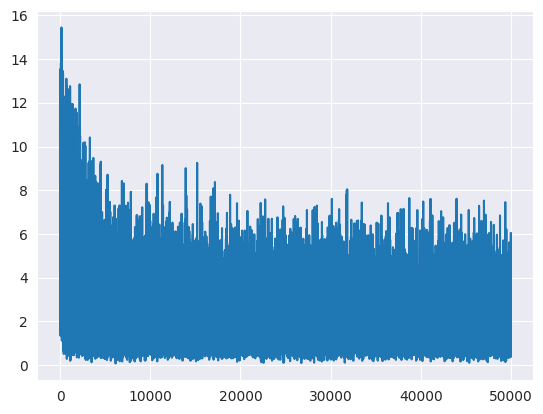

In [53]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(train_losses)

In [54]:
from datetime import datetime

now = datetime.now()

timestamp = now.strftime("%Y-%m-%d_%H:%M:%S")

In [55]:
name = "./weights/model_34_"+timestamp+".pth"
torch.save(model.state_dict(), name)

In [56]:
import pickle

name = "./results/losses_"+timestamp+".pickle"
with open(name, 'wb') as f:
    pickle.dump(train_losses, f)